## Printing statistics


In [4]:
import pandas as pd

date = "10.25"


def file_name_to_abbr(file_name):
    return " ".join(file_name.replace(".csv", "").replace("_", " ").title().split()[:2])


def load_datasets(date):
    data_dir = f"processed_data_{date}"
    return {
        "dp": pd.read_csv(f"{data_dir}/data_processing_{date}.csv"),
        "mc": pd.read_csv(f"{data_dir}/model_conversion_{date}.csv"),
        "sg": pd.read_csv(f"{data_dir}/sketch_generation_{date}.csv"),
    }

## 3-split token consumption statistics


In [3]:
import pandas as pd
import numpy as np
import os

date = "10.25"
data_dir = f"processed_data_{date}"


def calculate_stats(df, column):
    stats = {
        "average": df[column].mean(),
        "median": df[column].median(),
        "maximum": df[column].max(),
        "minimum": df[column].min(),
    }
    if "token" in column:
        return {k: int(v) for k, v in stats.items()}
    return stats


# Prepare a list to store all data
all_data = []

# Traverse the directory and process each CSV file
for file_name in os.listdir(data_dir):
    if file_name.endswith(".csv"):
        # Read the CSV file
        df = pd.read_csv(f"{data_dir}/{file_name}")

        stage_name = " ".join(
            file_name.replace(".csv", "").replace("_", " ").title().split()[:2]
        )
        print(f"- {stage_name}")

        # Calculate statistics for each specified column
        stats = {
            "overall_tokens": calculate_stats(df, "total_tokens"),
            "input_tokens": calculate_stats(df, "input_tokens"),
            "output_tokens": calculate_stats(df, "output_tokens"),
        }

        # Append the data to the list
        all_data.append(
            {
                "Stage": " ".join(
                    file_name.replace(".csv", "").replace("_", " ").title().split()[:2]
                ),
                "Overall Tokens Ave": stats["overall_tokens"]["average"],
                "Overall Tokens Med": stats["overall_tokens"]["median"],
                "Overall Tokens Max": stats["overall_tokens"]["maximum"],
                "Overall Tokens Min": stats["overall_tokens"]["minimum"],
                "Input Tokens Ave": stats["input_tokens"]["average"],
                "Input Tokens Med": stats["input_tokens"]["median"],
                "Input Tokens Max": stats["input_tokens"]["maximum"],
                "Input Tokens Min": stats["input_tokens"]["minimum"],
                "Output Tokens Ave": stats["output_tokens"]["average"],
                "Output Tokens Med": stats["output_tokens"]["median"],
                "Output Tokens Max": stats["output_tokens"]["maximum"],
                "Output Tokens Min": stats["output_tokens"]["minimum"],
            }
        )

# Create a DataFrame from the list
df_all_data = pd.DataFrame(all_data)

# Print the DataFrame as a table
print(df_all_data.to_string(index=False))


# Define the order of stages
stage_order = ["Data Processing", "Model Conversion", "Sketch Generation"]
stage_abbr = {
    "Data Processing": "DP",
    "Model Conversion": "MC",
    "Sketch Generation": "SG",
}

# Generate LaTeX table
latex_table = r"""
\begin{table}[!hp]
    \centering
    \resizebox{\textwidth}{!}{%
    \begin{tabular}{|l|r|r|r|r|r|r|r|r|r|r|r|r|}
    \hline
    \multicolumn{1}{|c|}{} &
      \multicolumn{4}{c|}{Overall Token Consumption} &
      \multicolumn{4}{c|}{Input Token Consumption} &
      \multicolumn{4}{c|}{Output Token Consumption} \\ \cline{2-13}
    \multicolumn{1}{|c|}{\multirow{-2}{*}{Stages}} &
      \multicolumn{1}{c|}{Ave} &
      \multicolumn{1}{c|}{Med} &
      \multicolumn{1}{c|}{Max} &
      \multicolumn{1}{c|}{Min} &
      \multicolumn{1}{c|}{Ave} &
      \multicolumn{1}{c|}{Med} &
      \multicolumn{1}{c|}{Max} &
      \multicolumn{1}{c|}{Min} &
      \multicolumn{1}{c|}{Ave} &
      \multicolumn{1}{c|}{Med} &
      \multicolumn{1}{c|}{Max} &
      \multicolumn{1}{c|}{Min} \\ \hline
"""

# Add rows to the LaTeX table in the specified order
for stage in stage_order:
    row = df_all_data[df_all_data["Stage"] == stage].iloc[0]
    latex_table += f"    {stage_abbr[stage]} & {row['Overall Tokens Ave']} & {row['Overall Tokens Med']} & {row['Overall Tokens Max']} & {row['Overall Tokens Min']} & {row['Input Tokens Ave']} & {row['Input Tokens Med']} & {row['Input Tokens Max']} & {row['Input Tokens Min']} & {row['Output Tokens Ave']} & {row['Output Tokens Med']} & {row['Output Tokens Max']} & {row['Output Tokens Min']} \\\\ \\hline\n"

latex_table += rf"""
    \end{{tabular}}%
    }}
    \caption{{Token consumption regarding Overall, Input, and Output in three stages on {date}.}}
    \label{{tab:detailed_token_consumption_{date}}}
    \end{{table}}
"""

# Print the LaTeX table
print(latex_table)

output_dir = "tex"
os.makedirs(output_dir, exist_ok=True)
output_file = f"{output_dir}/tab_detailed_token_consumption_{date}.tex"
with open(output_file, "w") as file:
    file.write(latex_table)
print(f"LaTeX table saved to {output_file}")

- Model Conversion
- Sketch Generation
- Data Processing
            Stage  Overall Tokens Ave  Overall Tokens Med  Overall Tokens Max  Overall Tokens Min  Input Tokens Ave  Input Tokens Med  Input Tokens Max  Input Tokens Min  Output Tokens Ave  Output Tokens Med  Output Tokens Max  Output Tokens Min
 Model Conversion                 793                 567                4035                 534               508               299              3463               299                284                268                572                235
Sketch Generation               13028               13747               16602                1731              9382              9829             12652              1255               3646               3932               4874                476
  Data Processing               11074               10446               21777                8587              8515              8076             17517              6688               2559               23

## Time statistics


In [7]:
import pandas as pd
import os

data_dir = "processed_data_10.02"
tex_dir = "tex"
date = "10.25"  # Assuming the date is part of the directory name


def calculate_latency_stats(df):
    return {
        "average": df["latency"].mean(),
        "median": df["latency"].median(),
        "maximum": df["latency"].max(),
        "minimum": df["latency"].min(),
    }


# Ensure the tex directory exists
os.makedirs(tex_dir, exist_ok=True)

# Traverse the directory and process each CSV file
print(
    "{:<15} {:<10} {:<10} {:<10} {:<10}".format(
        "Stages", "Time Ave", "Time Med", "Time Max", "Time Min"
    )
)

# Dictionary to store stats for LaTeX table
latex_stats = {}

# Mapping of file names to task abbreviations
task_mapping = {
    "Data Processing": "DP",
    "Model Conversion": "MC",
    "Sketch Generation": "SG",
}

for file_name in os.listdir(data_dir):
    if file_name.endswith(".csv"):
        # Read the CSV file
        df = pd.read_csv(f"{data_dir}/{file_name}")

        # Calculate latency statistics
        latency_stats = calculate_latency_stats(df)

        # Determine task abbreviation
        task_key = file_name_to_abbr(file_name)
        task_name = task_mapping.get(task_key)
        if task_name:
            # Print results in table format
            print("-" * 55)
            print(
                "{:<15} {:<10.2f} {:<10.2f} {:<10.2f} {:<10.2f}".format(
                    task_name,
                    latency_stats["average"],
                    latency_stats["median"],
                    latency_stats["maximum"],
                    latency_stats["minimum"],
                )
            )

            # Store stats for LaTeX table
            latex_stats[task_name] = latency_stats
        else:
            print(f"Warning: Unrecognized task for file {file_name}")

# Check if all required stats are available
required_keys = ["DP", "MC", "SG"]
print("latex_stats", latex_stats)
missing_keys = [key for key in required_keys if key not in latex_stats]

if missing_keys:
    print(f"Error: Missing data for tasks: {', '.join(missing_keys)}")
else:
    # LaTeX table preamble
    latex_preamble = r"""
    \begin{table}[!h]
        \centering
        \resizebox{0.6\textwidth}{!}{%
        \begin{tabular}{|l|r|r|r|r|}
        \hline
        \multicolumn{1}{|c|}{} &
          \multicolumn{4}{c|}{Total Time (s)} \\ \cline{2-5}
        \multicolumn{1}{|c|}{\multirow{-2}{*}{Stages}} &
          \multicolumn{1}{c|}{Ave} &
          \multicolumn{1}{c|}{Med} &
          \multicolumn{1}{c|}{Max} &
          \multicolumn{1}{c|}{Min} \\ \hline
    """

    # LaTeX table data filling
    latex_data = ""
    for stage, abbr in [
        ("Data Processing", "DP"),
        ("Model Conversion", "MC"),
        ("Sketch Generation", "SG"),
    ]:
        if abbr in latex_stats:
            stats = latex_stats[abbr]
            latex_data += f"{abbr} & {stats['average']:.2f} & {stats['median']:.2f} & {stats['maximum']:.2f} & {stats['minimum']:.2f} \\\\ \\hline\n"

    # LaTeX table postamble
    latex_postamble = rf"""
        \end{{tabular}}%
        }}
        \caption{{Time consumption on {date}.}}
        \label{{tab:time_consumption_{date}}}
        \end{{table}}
    """

    # Combine all parts
    latex_content = latex_preamble + latex_data + latex_postamble

    output_file = f"{tex_dir}/time_consumption_{date}.tex"
    # Save LaTeX table to file
    with open(output_file, "w") as tex_file:
        tex_file.write(latex_content)
    print(f"LaTeX table saved to {output_file}")

Stages          Time Ave   Time Med   Time Max   Time Min  
-------------------------------------------------------
SG              117.86     115.15     242.87     7.13      
-------------------------------------------------------
DP              39.38      30.39      121.11     2.81      
-------------------------------------------------------
MC              18.62      14.78      48.33      6.34      
latex_stats {'SG': {'average': 117.8616481, 'median': 115.1482015, 'maximum': 242.870417, 'minimum': 7.130455}, 'DP': {'average': 39.3777745, 'median': 30.3852625, 'maximum': 121.111455, 'minimum': 2.806248}, 'MC': {'average': 18.62416753333333, 'median': 14.7833285, 'maximum': 48.329224, 'minimum': 6.335037}}
LaTeX table saved to tex/time_consumption_10.25.tex


## Monetary cost statistics


In [9]:
import pandas as pd
import os

date = "10.25"
data_dir = f"processed_data_{date}"


def calculate_stats(df, column):
    stats = {
        "average": df[column].mean() * 100,  # Convert to cents
        "median": df[column].median() * 100,  # Convert to cents
        "maximum": df[column].max() * 100,  # Convert to cents
        "minimum": df[column].min() * 100,  # Convert to cents
    }
    return stats


# Prepare a list to store all data
all_data = []

# Traverse the directory and process each CSV file
for file_name in os.listdir(data_dir):
    if file_name.endswith(".csv"):
        # Read the CSV file
        df = pd.read_csv(f"{data_dir}/{file_name}")

        # Calculate statistics for each specified column
        stats = {
            "overall_cost": calculate_stats(df, "total_cost"),
            "input_cost": calculate_stats(df, "input_cost"),
            "output_cost": calculate_stats(df, "output_cost"),
        }

        # Append the data to the list
        all_data.append(
            {
                "Stage": file_name_to_abbr(file_name),
                "Overall Cost Ave": stats["overall_cost"]["average"],
                "Overall Cost Med": stats["overall_cost"]["median"],
                "Overall Cost Max": stats["overall_cost"]["maximum"],
                "Overall Cost Min": stats["overall_cost"]["minimum"],
                "Input Cost Ave": stats["input_cost"]["average"],
                "Input Cost Med": stats["input_cost"]["median"],
                "Input Cost Max": stats["input_cost"]["maximum"],
                "Input Cost Min": stats["input_cost"]["minimum"],
                "Output Cost Ave": stats["output_cost"]["average"],
                "Output Cost Med": stats["output_cost"]["median"],
                "Output Cost Max": stats["output_cost"]["maximum"],
                "Output Cost Min": stats["output_cost"]["minimum"],
            }
        )

# Create a DataFrame from the list
df_all_data = pd.DataFrame(all_data)

# Print the DataFrame as a table
print(df_all_data.to_string(index=False))

# Define the order of stages
stage_order = ["Data Processing", "Model Conversion", "Sketch Generation"]
stage_abbr = {
    "Data Processing": "DP",
    "Model Conversion": "MC",
    "Sketch Generation": "SG",
}

# Generate LaTeX table
latex_table = r"""
\begin{table}[!hp]
    \centering
    \resizebox{\textwidth}{!}{%
    \begin{tabular}{|l|r|r|r|r|r|r|r|r|r|r|r|r|}
    \hline
    \multicolumn{1}{|c|}{} &
      \multicolumn{4}{c|}{Overall Cost (USD cents)} &
      \multicolumn{4}{c|}{Input Cost (USD cents)} &
      \multicolumn{4}{c|}{Output Cost (USD cents)} \\ \cline{2-13}
    \multicolumn{1}{|c|}{\multirow{-2}{*}{Stages}} &
      \multicolumn{1}{c|}{Ave} &
      \multicolumn{1}{c|}{Med} &
      \multicolumn{1}{c|}{Max} &
      \multicolumn{1}{c|}{Min} &
      \multicolumn{1}{c|}{Ave} &
      \multicolumn{1}{c|}{Med} &
      \multicolumn{1}{c|}{Max} &
      \multicolumn{1}{c|}{Min} &
      \multicolumn{1}{c|}{Ave} &
      \multicolumn{1}{c|}{Med} &
      \multicolumn{1}{c|}{Max} &
      \multicolumn{1}{c|}{Min} \\ \hline
"""

# Add rows to the LaTeX table in the specified order
for stage in stage_order:
    row = df_all_data[df_all_data["Stage"] == stage].iloc[0]
    latex_table += (
        f"    {stage_abbr[stage]} & "
        f"{row['Overall Cost Ave']:.2f} & {row['Overall Cost Med']:.2f} & "
        f"{row['Overall Cost Max']:.2f} & {row['Overall Cost Min']:.2f} & "
        f"{row['Input Cost Ave']:.2f} & {row['Input Cost Med']:.2f} & "
        f"{row['Input Cost Max']:.2f} & {row['Input Cost Min']:.2f} & "
        f"{row['Output Cost Ave']:.2f} & {row['Output Cost Med']:.2f} & "
        f"{row['Output Cost Max']:.2f} & {row['Output Cost Min']:.2f} \\\\ \\hline\n"
    )

latex_table += rf"""
    \end{{tabular}}%
    }}
    \caption{{Cost statistics regarding Overall, Input, and Output in three stages on {date}.}}
    \label{{tab:detailed_cost_statistics_{date}}}
    \end{{table}}
"""

# Print the LaTeX table
print(latex_table)

output_dir = "tex"
os.makedirs(output_dir, exist_ok=True)
output_file = f"{output_dir}/tab_detailed_cost_statistics_{date}.tex"
with open(output_file, "w") as file:
    file.write(latex_table)
print(f"LaTeX table saved to {output_file}")

            Stage  Overall Cost Ave  Overall Cost Med  Overall Cost Max  Overall Cost Min  Input Cost Ave  Input Cost Med  Input Cost Max  Input Cost Min  Output Cost Ave  Output Cost Med  Output Cost Max  Output Cost Min
 Model Conversion          0.681317           0.55150            2.5895            0.5020        0.254317         0.14950          1.7315          0.1495           0.4270          0.40200           0.8580           0.3525
Sketch Generation         10.160850          10.83975           12.5790            1.3415        4.691150         4.91475          6.3260          0.6275           5.4697          5.89875           7.3110           0.7140
  Data Processing          8.096883           7.53525           15.1485            6.1245        4.257583         4.03800          8.7585          3.3440           3.8393          3.55350           6.6705           2.7465

\begin{table}[!hp]
    \centering
    \resizebox{\textwidth}{!}{%
    \begin{tabular}{|l|r|r|r|r|r|r|r|r|r|r|r|

## time and token, avg, min, max, and success rate


## Print in a table: total_tokens and latency


In [17]:
def calculate_stats(df, column):
    if len(df) == 0:  # Handle empty DataFrame
        return {
            "average": 0,
            "minimum": 0,
            "maximum": 0,
        }

    stats = {
        "average": df[column].mean(),
        "minimum": df[column].min(),
        "maximum": df[column].max(),
    }
    if "token" in column:
        return {k: int(v) for k, v in stats.items()}
    return stats


def calculate_stats_by_status(df, status=None):
    if status is not None:
        subset = df[df["pass"] == status]
        # Debug print
        print(f"\nDebug - Rows with status '{status}': {len(subset)}")
        if len(subset) == 0:
            print(f"No rows found with pass = '{status}'")
    else:
        subset = df
        print(f"\nDebug - Total rows: {len(subset)}")

    # Debug print for NaN values
    print("\nColumns with NaN values:")
    print(subset.isna().sum())

    return {
        "total_tokens": calculate_stats(subset, "total_tokens"),
        "latency": calculate_stats(subset, "latency"),
    }


def print_stats_table(df, task_name):
    # Calculate stats
    overall_stats = calculate_stats_by_status(df)
    passed_stats = calculate_stats_by_status(df, "yes")
    failed_stats = calculate_stats_by_status(df, "no")
    success_rate = (df["pass"] == "yes").mean() * 100

    print(f"\n=== {task_name} ===")
    print(
        "{:<15} {:<15} {:<12} {:<12} {:<12}".format(
            "Status", "Metric", "Average", "Minimum", "Maximum"
        )
    )
    print("-" * 66)

    # Create rows for latency
    for status, stats in [
        ("Overall", overall_stats),
        ("Passed", passed_stats),
        ("Failed", failed_stats),
    ]:
        print(
            "{:<15} {:<15} {:<12.2f} {:<12.2f} {:<12.2f}".format(
                status,
                "latency",
                stats["latency"]["average"],
                stats["latency"]["minimum"],
                stats["latency"]["maximum"],
            )
        )

    # Print blank line between metrics
    print()

    # Create rows for total_tokens
    for status, stats in [
        ("Overall", overall_stats),
        ("Passed", passed_stats),
        ("Failed", failed_stats),
    ]:
        print(
            "{:<15} {:<15} {:<12.2f} {:<12.2f} {:<12.2f}".format(
                status,
                "total_tokens",
                stats["total_tokens"]["average"],
                stats["total_tokens"]["minimum"],
                stats["total_tokens"]["maximum"],
            )
        )

    print(f"\nSuccess rate: {success_rate:.2f}%")


# Load all datasets
df_sketch_generator = pd.read_csv(f"{data_dir}/sketch_generation_{date}.csv")
df_data_processing = pd.read_csv(f"{data_dir}/data_processing_{date}.csv")
df_model_convert = pd.read_csv(f"{data_dir}/model_conversion_{date}.csv")

# Print stats for each dataset
print_stats_table(df_sketch_generator, "Sketch Generation")
print_stats_table(df_data_processing, "Data Processing")
print_stats_table(df_model_convert, "Model Conversion")


Debug - Total rows: 30

Columns with NaN values:
name             0
latency          0
time             0
num_run          0
total_tokens     0
input_tokens     0
output_tokens    0
total_cost       0
input_cost       0
output_cost      0
pass             0
task             0
dtype: int64

Debug - Rows with status 'yes': 9

Columns with NaN values:
name             0
latency          0
time             0
num_run          0
total_tokens     0
input_tokens     0
output_tokens    0
total_cost       0
input_cost       0
output_cost      0
pass             0
task             0
dtype: int64

Debug - Rows with status 'no': 21

Columns with NaN values:
name             0
latency          0
time             0
num_run          0
total_tokens     0
input_tokens     0
output_tokens    0
total_cost       0
input_cost       0
output_cost      0
pass             0
task             0
dtype: int64

=== Sketch Generation ===
Status          Metric          Average      Minimum      Maximum     
-------

## For latex table


In [24]:
import pandas as pd
import os

date = "10.25"
data_dir = f"processed_data_{date}"


def calculate_stats(df, column):
    if len(df) == 0:  # Handle empty DataFrame
        return {
            "average": 0,
            "minimum": 0,
            "maximum": 0,
        }

    stats = {
        "average": df[column].mean(),
        "minimum": df[column].min(),
        "maximum": df[column].max(),
    }
    if "token" in column:
        return {k: int(v) for k, v in stats.items()}
    return stats


def calculate_stats_by_status(df, status=None):
    if status is not None:
        subset = df[df["pass"] == status]
    else:
        subset = df
    return {
        "total_tokens": calculate_stats(subset, "total_tokens"),
        "latency": calculate_stats(subset, "latency"),
    }


def generate_latex_table(df_sketch_generator, df_data_processing, df_model_convert):
    # Calculate stats for each dataset
    datasets = {
        "SG": df_sketch_generator,
        "DP": df_data_processing,
        "MC": df_model_convert,
    }

    stats = {}
    for key, df in datasets.items():
        overall_stats = calculate_stats_by_status(df)
        passed_stats = calculate_stats_by_status(df, "yes")
        failed_stats = calculate_stats_by_status(df, "no")
        success_rate = (df["pass"] == "yes").mean() * 100

        stats[key] = {
            "time_overall": overall_stats["latency"]["average"],
            "time_passed": passed_stats["latency"]["average"],
            "time_failed": failed_stats["latency"]["average"],
            "tokens_overall": overall_stats["total_tokens"]["average"],
            "tokens_passed": passed_stats["total_tokens"]["average"],
            "tokens_failed": failed_stats["total_tokens"]["average"],
            "success_rate": success_rate,
        }

    # Generate LaTeX table
    latex_table = r"""
\begin{table}[!h]
  \centering
  \resizebox{\textwidth}{!}{%
  \begin{tabular}{|l|lll|lll|c|}
  \hline
  \multicolumn{1}{|c|}{} & \multicolumn{3}{c|}{Ave. Time (s)}  & \multicolumn{3}{c|}{Ave. Total Tokens}   & \multicolumn{1}{l|}{} \\ \cline{2-7}
  \multicolumn{1}{|c|}{\multirow{-2}{*}{Stages}} &
    \multicolumn{1}{c|}{Overall} &
    \multicolumn{1}{c|}{Passed} &
    \multicolumn{1}{c|}{Failed} &
    \multicolumn{1}{c|}{Overall} &
    \multicolumn{1}{c|}{Passed} &
    \multicolumn{1}{c|}{Failed} &
    \multicolumn{1}{c|}{\multirow{-2}{*}{Success Rate}} \\ \hline
"""

    for stage, abbr in [
        ("Data Processing", "DP"),
        ("Model Convert", "MC"),
        ("Sketch Generator", "SG"),
    ]:
        latex_table += (
            f"  {abbr} & "
            f"\\multicolumn{{1}}{{l|}}{{{stats[abbr]['time_overall']:.2f}}} & "
            f"\\multicolumn{{1}}{{l|}}{{{stats[abbr]['time_passed']:.2f}}} & "
            f"{stats[abbr]['time_failed']:.2f} & "
            f"\\multicolumn{{1}}{{l|}}{{{stats[abbr]['tokens_overall']}}} & "
            f"\\multicolumn{{1}}{{l|}}{{{stats[abbr]['tokens_passed']}}} & "
            f"{stats[abbr]['tokens_failed']} & "
            f"{stats[abbr]['success_rate']/100:.3f} \\\\ \\hline\n"
        )

    latex_table += rf"""  \end{{tabular}}%
  }}
  \caption{{Performance metrics regarding overall, passed, and failed runs on {date}.}}
  \label{{tab:performance_metrics_{date}}}
\end{{table}}
"""

    # Print the LaTeX table
    print(latex_table)
    output_dir = "tex"
    os.makedirs(output_dir, exist_ok=True)
    output_file = f"{output_dir}/tab_time_token_pass_fail_{date}.tex"
    with open(output_file, "w") as file:
        file.write(latex_table)
    print(f"LaTeX table saved to {output_file}")


# Load all datasets
datasets = load_datasets("10.25")

df_data_processing = datasets["dp"]
df_model_convert = datasets["mc"]
df_sketch_generator = datasets["sg"]

# Generate and print the LaTeX table
generate_latex_table(df_sketch_generator, df_data_processing, df_model_convert)


\begin{table}[!h]
  \centering
  \resizebox{\textwidth}{!}{%
  \begin{tabular}{|l|lll|lll|c|}
  \hline
  \multicolumn{1}{|c|}{} & \multicolumn{3}{c|}{Ave. Time (s)}  & \multicolumn{3}{c|}{Ave. Total Tokens}   & \multicolumn{1}{l|}{} \\ \cline{2-7}
  \multicolumn{1}{|c|}{\multirow{-2}{*}{Stages}} &
    \multicolumn{1}{c|}{Overall} &
    \multicolumn{1}{c|}{Passed} &
    \multicolumn{1}{c|}{Failed} &
    \multicolumn{1}{c|}{Overall} &
    \multicolumn{1}{c|}{Passed} &
    \multicolumn{1}{c|}{Failed} &
    \multicolumn{1}{c|}{\multirow{-2}{*}{Success Rate}} \\ \hline
  DP & \multicolumn{1}{l|}{44.17} & \multicolumn{1}{l|}{44.17} & 0.00 & \multicolumn{1}{l|}{11074} & \multicolumn{1}{l|}{11074} & 0 & 1.000 \\ \hline
  MC & \multicolumn{1}{l|}{8.87} & \multicolumn{1}{l|}{8.87} & 0.00 & \multicolumn{1}{l|}{793} & \multicolumn{1}{l|}{793} & 0 & 1.000 \\ \hline
  SG & \multicolumn{1}{l|}{117.86} & \multicolumn{1}{l|}{113.86} & 119.58 & \multicolumn{1}{l|}{13028} & \multicolumn{1}{l|}{10094} & 

## Plotting bar chart


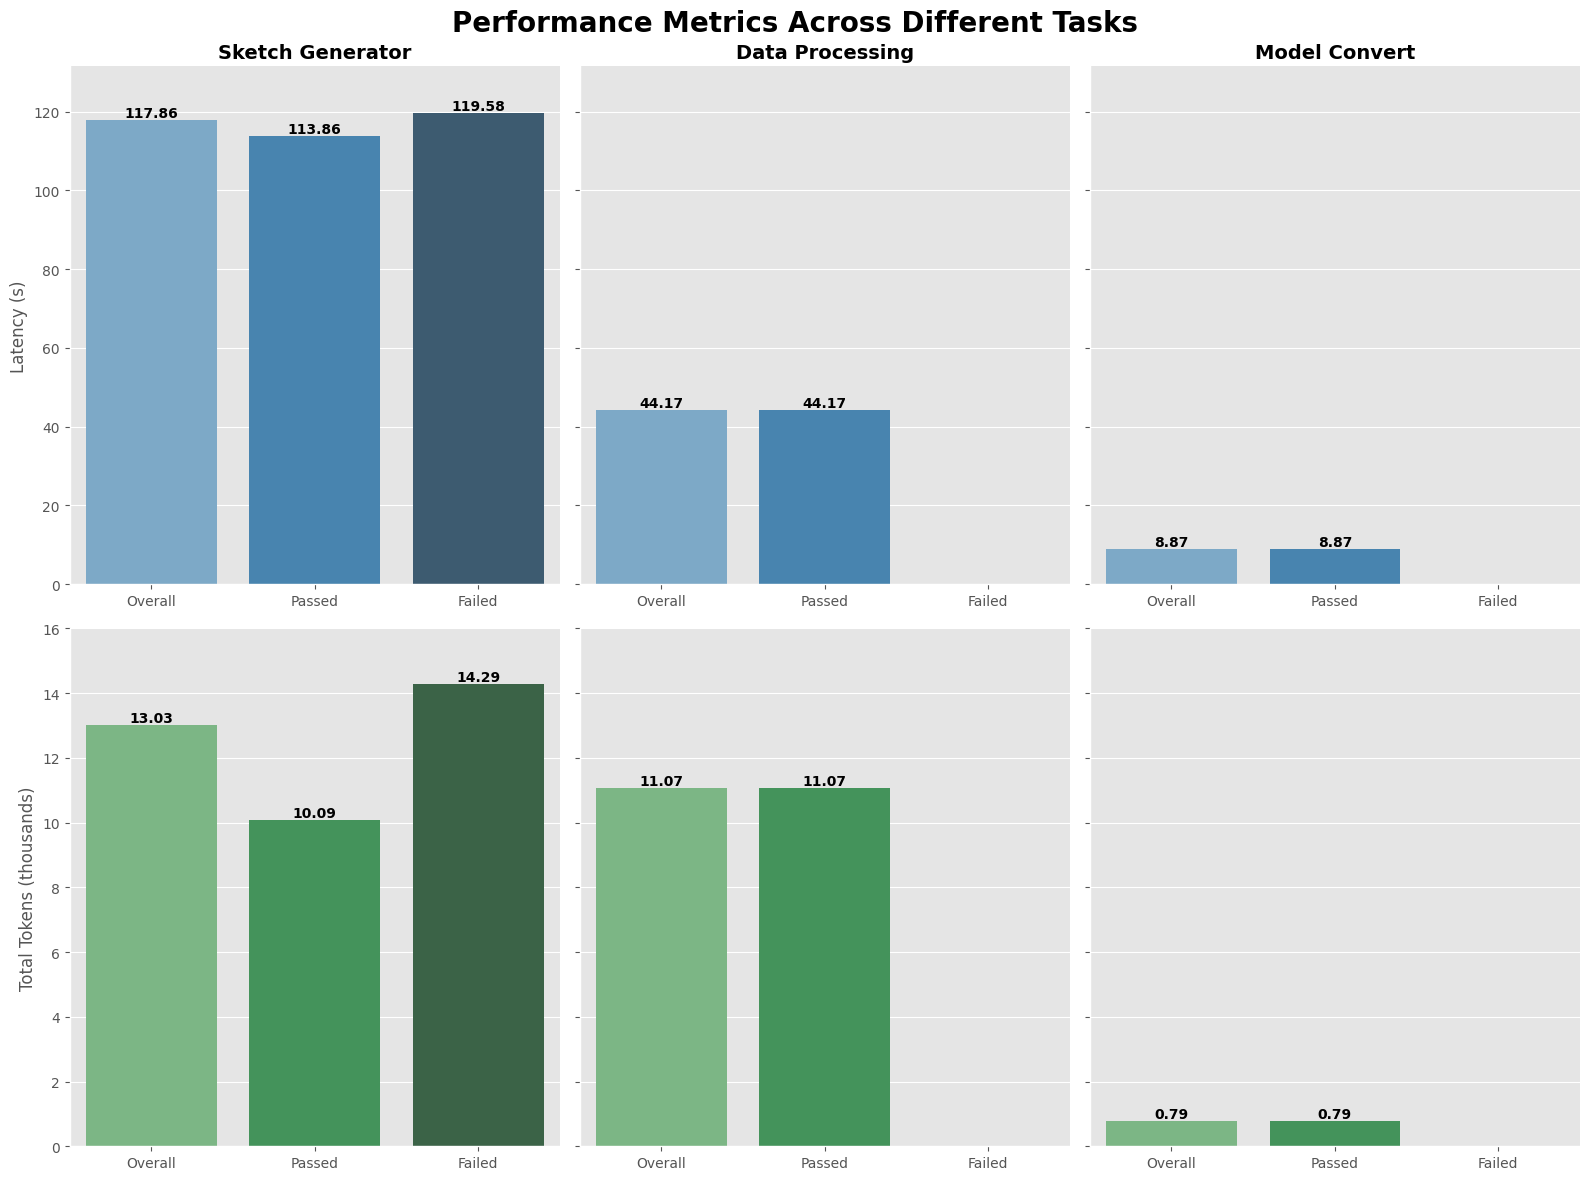

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

date = "10.25"
data_dir = f"processed_data_{date}"

# Load all datasets
df_sketch_generator = pd.read_csv(f"{data_dir}/sketch_generation_{date}.csv")
df_data_processing = pd.read_csv(f"{data_dir}/data_processing_{date}.csv")
df_model_convert = pd.read_csv(f"{data_dir}/model_conversion_{date}.csv")


def calculate_stats(df, column):
    return {
        "average": df[column].mean(),
        "minimum": df[column].min(),
        "maximum": df[column].max(),
    }


def calculate_stats_by_status(df, status=None):
    if status is not None:
        subset = df[df["pass"] == status]
    else:
        subset = df
    return {
        "total_tokens": calculate_stats(subset, "total_tokens"),
        "latency": calculate_stats(subset, "latency"),
    }


def prepare_data_for_plot(df, task_name):
    overall_stats = calculate_stats_by_status(df)
    passed_stats = calculate_stats_by_status(df, "yes")
    failed_stats = calculate_stats_by_status(df, "no")

    data = []
    for metric in ["latency", "total_tokens"]:
        for status, stats in [
            ("Overall", overall_stats),
            ("Passed", passed_stats),
            ("Failed", failed_stats),
        ]:
            data.append(
                {
                    "Task": task_name,
                    "Metric": metric,
                    "Status": status,
                    "Average": stats[metric]["average"],
                    "Minimum": stats[metric]["minimum"],
                    "Maximum": stats[metric]["maximum"],
                }
            )
    return pd.DataFrame(data)


# Prepare data for plotting
df_sketch = prepare_data_for_plot(df_sketch_generator, "Sketch Generator")
df_data = prepare_data_for_plot(df_data_processing, "Data Processing")
df_model = prepare_data_for_plot(df_model_convert, "Model Convert")

# Combine all data
df_all = pd.concat([df_sketch, df_data, df_model])

# Determine global y-axis limits
latency_max = df_all[df_all["Metric"] == "latency"]["Average"].max()
tokens_max = df_all[df_all["Metric"] == "total_tokens"]["Average"].max()

# ... (keep the data loading and preparation code unchanged)

# Set the style
plt.style.use("ggplot")
sns.set_palette("muted")

# Plotting
tasks = df_all["Task"].unique()
fig, axes = plt.subplots(nrows=2, ncols=len(tasks), figsize=(16, 12), sharey="row")

for col, task in enumerate(tasks):
    task_data = df_all[df_all["Task"] == task]

    # Plot latency
    ax_latency = axes[0, col]
    latency_data = task_data[task_data["Metric"] == "latency"]
    sns.barplot(
        x="Status",
        y="Average",
        data=latency_data,
        ax=ax_latency,
        hue="Status",
        palette="Blues_d",
        legend=False,
    )
    ax_latency.set_ylabel("Latency (s)" if col == 0 else "")
    ax_latency.set_ylim(0, latency_max * 1.1)
    ax_latency.set_title(task, fontsize=14, fontweight="bold")

    # Annotate latency bars
    for i, bar in enumerate(ax_latency.patches):
        yval = bar.get_height()
        ax_latency.text(
            bar.get_x() + bar.get_width() / 2,
            yval,
            f"{yval:.2f}",
            ha="center",
            va="bottom",
            fontweight="bold",
        )

    # Plot total tokens
    ax_tokens = axes[1, col]
    tokens_data = task_data[task_data["Metric"] == "total_tokens"]
    sns.barplot(
        x="Status",
        y="Average",
        data=tokens_data,
        ax=ax_tokens,
        hue="Status",
        palette="Greens_d",
        legend=False,
    )
    ax_tokens.set_ylabel("Total Tokens (thousands)" if col == 0 else "")
    ax_tokens.set_ylim(0, tokens_max * 1.1)

    # Set y-axis ticks manually
    y_ticks = ax_tokens.get_yticks()
    ax_tokens.set_yticks(y_ticks)
    ax_tokens.set_yticklabels([f"{int(tick/1000)}" for tick in y_ticks])

    # Annotate token bars
    for i, bar in enumerate(ax_tokens.patches):
        yval = bar.get_height()
        ax_tokens.text(
            bar.get_x() + bar.get_width() / 2,
            yval,
            f"{yval/1000:.2f}",
            ha="center",
            va="bottom",
            fontweight="bold",
        )

    # Improve readability
    for ax in [ax_latency, ax_tokens]:
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.tick_params(axis="both", which="major", labelsize=10)
        ax.set_xlabel("")

# Add overall title
fig.suptitle(
    "Performance Metrics Across Different Tasks", fontsize=20, fontweight="bold", y=0.98
)

# Adjust layout
plt.tight_layout()
plt.savefig(f"metrics_time_token_pass_fail_{date}.pdf", format="pdf", dpi=400)
plt.show()

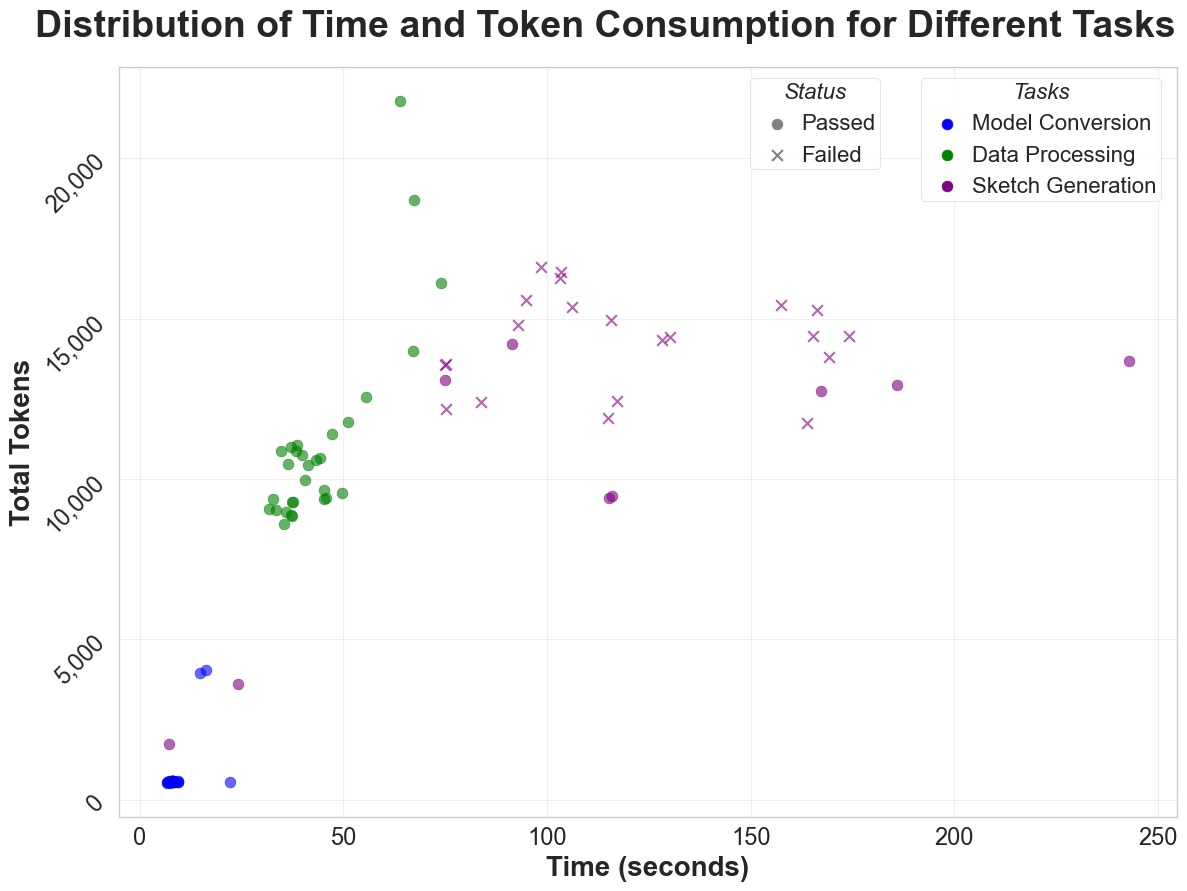

In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mticker

title_fontweight = 800
label_fontweight = 600
tick_fontweight = 400
legend_fontweight = "normal"
legend_fontweight2 = "normal"

title_fontsize = 27
label_fontsize = 20
tick_fontsize = 18
legend_fontsize = 16

mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["ps.fonttype"] = 42
# data_dir = "processed_data"
# Load the data from CSV files
datasets = load_datasets("10.25")
df_sketch_generator = datasets["sg"]
df_data_processing = datasets["dp"]
df_model_convert = datasets["mc"]

# Combine all dataframes into a single dataframe with an additional 'task' column
df_sketch_generator["task"] = "Sketch Generation"
df_data_processing["task"] = "Data Processing"
df_model_convert["task"] = "Model Conversion"

df_combined = pd.concat([df_sketch_generator, df_data_processing, df_model_convert])

# Set the style
sns.set_style("whitegrid")

# Create the figure
plt.figure(figsize=(12, 9))

# Define colors and markers for each task
task_colors = {
    "Model Conversion": "blue",
    "Data Processing": "green",
    "Sketch Generation": "purple",
}

task_markers = {
    "yes": "o",  # Circle for successful runs
    "no": "x",  # Cross for failed runs
}

# Plot each task with different colors and markers
for task, color in task_colors.items():
    task_data = df_combined[df_combined["task"] == task]

    # Plot passed runs
    passed = task_data[task_data["pass"] == "yes"]
    plt.scatter(
        passed["latency"],
        passed["total_tokens"],
        color=color,
        alpha=0.6,
        label=task,  # Label only with task name
        marker="o",  # Circle for passed
        s=60,
    )

    # Plot failed runs without labels (to avoid task repetition in legend)
    failed = task_data[task_data["pass"] == "no"]
    plt.scatter(
        failed["latency"],
        failed["total_tokens"],
        color=color,
        alpha=0.6,
        marker="x",  # X for failed
        s=60,
    )

# Set labels and title
plt.xlabel("Time (seconds)", fontsize=label_fontsize, fontweight=label_fontweight)
plt.ylabel("Total Tokens", fontsize=label_fontsize, fontweight=label_fontweight)
plt.title(
    "Distribution of Time and Token Consumption for Different Tasks",
    fontsize=title_fontsize,
    loc="center",
    x=0.46,
    y=1.03,
    fontweight=title_fontweight,
)
plt.tick_params(
    axis="both",
    which="major",
    labelsize=17,
)

# Format the y-axis numbers with commas
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: f"{int(y):,}"))

# Format the x-axis numbers with commas if needed
plt.gca().xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{int(x):,}"))
# Add separate pass/fail markers to legend
plt.scatter([], [], color="gray", marker="o", label="Passed", s=60)
plt.scatter([], [], color="gray", marker="x", label="Failed", s=60)

# Add legend
plt.yticks(rotation=45, ha="right", fontweight=tick_fontweight)
plt.xticks(fontweight=tick_fontweight)
# ... existing code until the legend section ...

# ... existing code remains the same until legend section ...

# Create two separate legend handles and labels
task_handles = []
task_labels = []
status_handles = []
status_labels = []

# Collect task handles and labels
for task, color in task_colors.items():
    task_handles.append(plt.scatter([], [], color=color, marker="o", s=60))
    task_labels.append(task)

# Add status handles and labels
status_handles.append(plt.scatter([], [], color="gray", marker="o", s=60))
status_handles.append(plt.scatter([], [], color="gray", marker="x", s=60))
status_labels.extend(["Passed", "Failed"])

legend_title_prop = {
    "weight": legend_fontweight,
    "size": legend_fontsize,
    "style": "italic",
}


# Create legend with two handle/label sets side by side
first_legend = plt.legend(
    task_handles,
    task_labels,
    loc="upper right",
    bbox_to_anchor=(0.995, 1.0),  # Position for first legend
    prop={"weight": legend_fontweight, "size": legend_fontsize},
    frameon=True,
    scatterpoints=1,
    markerscale=1,
    markerfirst=True,
    handletextpad=0.1,
    borderpad=0.2,
    edgecolor="lightgray",
    fancybox=True,
    shadow=False,
    framealpha=0.9,
    title="Tasks",
    title_fontproperties=legend_title_prop,
)

# Add the second legend for status markers
plt.gca().add_artist(first_legend)
plt.legend(
    status_handles,
    status_labels,
    loc="upper right",
    bbox_to_anchor=(
        0.73,
        1.0,
    ),  # Position for second legend - adjust this value to control horizontal spacing
    prop={"weight": legend_fontweight, "size": legend_fontsize},
    frameon=True,
    scatterpoints=1,
    markerscale=1,
    markerfirst=True,
    handletextpad=0.1,
    borderpad=0.2,
    edgecolor="lightgray",
    fancybox=True,
    shadow=False,
    framealpha=0.9,
    title="Status",
    title_fontproperties=legend_title_prop,
)

# ... rest of the code remains the same ...

# Add grid and show plot
plt.grid(True, linestyle="-", alpha=0.3)
plt.tight_layout()
plt.savefig(
    f"plot_scatter_{date}.pdf", format="pdf", dpi=400
)  # Removed bbox_inches='tight' as it's no longer needed
plt.show()